**In this tutorial, we will build CNN models to classify images.** \\
Notebook inspired by: \\
1) https://www.kaggle.com/code/zeadomar/breast-cancer-detection-with-cnn/notebook \\
2) https://victorzhou.com/blog/keras-cnn-tutorial/#the-full-code \\
3) https://cs231n.github.io/convolutional-networks/ \\

**Introduction**

Motivation: Regular Neural Nets don't scale well to full images. \\
ConvNets: Take advantage that inputs consists of image. \\
Layers of ConvNet have neurons arranged in 3 dimensions: **(width, height, depth)**

**Building the model**
1.   Main operations: Convolution, Pooling, and activation (prediction)

  Pooling: Average pooling was often used historically but has recently fallen out of favor compared to the max pooling operation, which has been shown to work better in practice.


cnn-dims-3.svg

**1. Feature extraction using convolution** \\


---



---




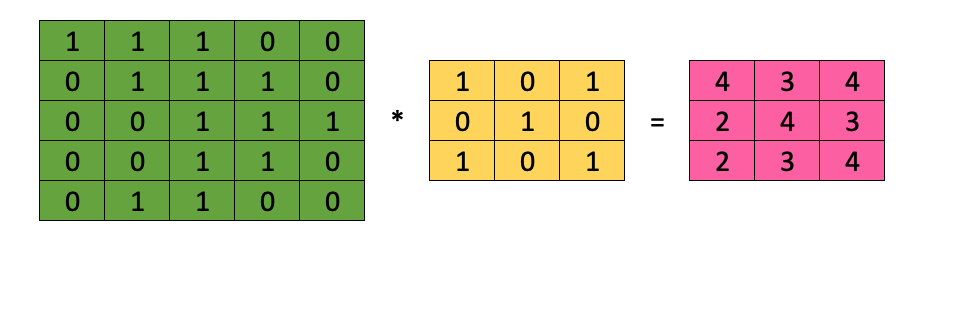


**1. Feature extraction using convolution** \\

---

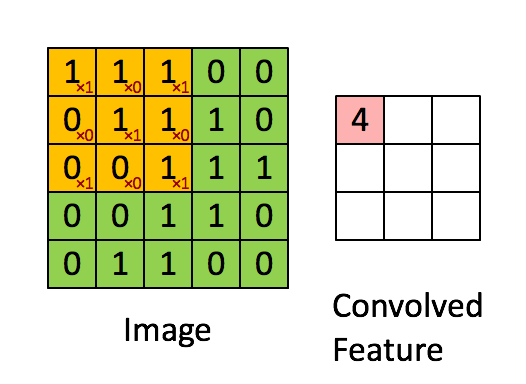

$$ output= \dfrac{W-F+2P}{S} + 1$$
where $W$ is the input size, \\
$F$ is the filter size, \\
$P$ is the padding size, \\
$W$ is the stride size. \\

**2. Pooling to reduce complexity** \\

---

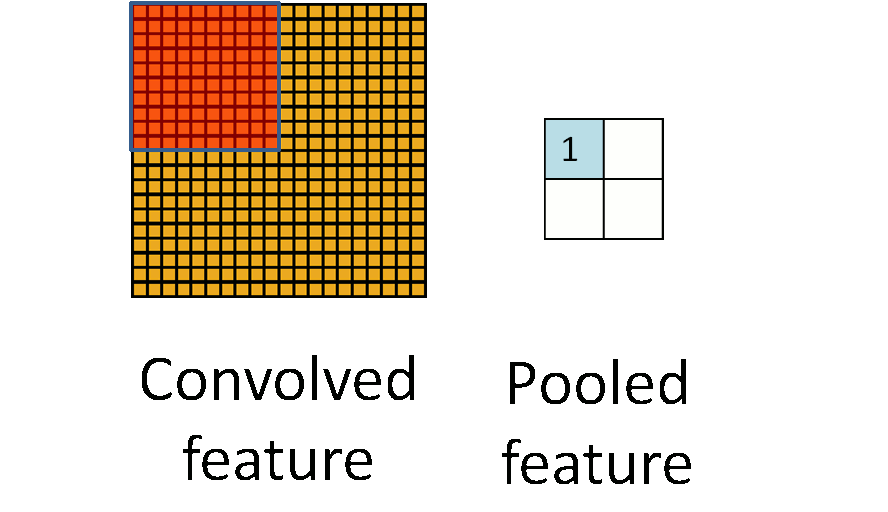

**Identification of handwritten digits (MNIST)**


---



In [1]:
import os
import numpy as np
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from matplotlib import pyplot
import matplotlib.image as mpimg

import torch
import torch.nn as nn
from torchvision.datasets import MNIST, FashionMNIST
from torchvision.transforms import ToTensor, Compose, Normalize, RandomHorizontalFlip, RandomRotation

In [2]:
# Loading the mnist images
# ToTensor sets the format to a torch tensor with CHW order
# Normalize normalizes the images (x = (x - mu) / std)
# Normalizing with mean 0.5 and std 1 sets the value between -0.5 and 0.5
transforms = Compose([ToTensor(), Normalize(0.5, 1)])
mnist_train = MNIST(".", download=True, train=True, transform=transforms)
mnist_test = MNIST(".", download=True, train=False, transform=transforms)

print(f"{len(mnist_train)=}")
print(f"{len(mnist_test)=}")

img, label = mnist_train[0]
print(f"{img.shape=}")
print(f"{label=}")

len(mnist_train)=60000
len(mnist_test)=10000
img.shape=torch.Size([1, 28, 28])
label=5


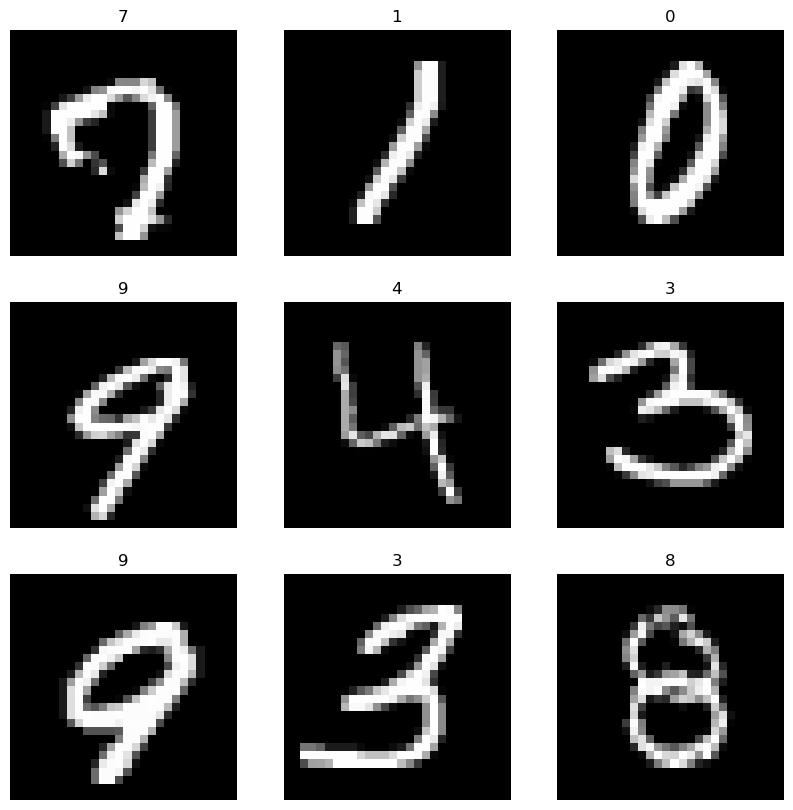

In [3]:
# Visualizing the MNIST images
sample_img_idx = np.random.randint(0, len(mnist_train), 9)
plt.figure(figsize=(10,10))
for i, j in enumerate(sample_img_idx):
    image, label = mnist_train[j]
    image = image[0]
    ax=plt.subplot(3,3,i+1)
    plt.imshow(image, cmap=pyplot.get_cmap('gray'))
    plt.title(label)
    plt.axis('off')

In [4]:
num_filters = 8
filter_size = 3
pool_size   = 2
num_classes = 10
batch_size  = 64
strides     = 1
padding     = 1  # Padding of 1 with filter size of 3 output the same dimension

class BasicCNN(nn.Module):
    def __init__(self):  
        super().__init__()
        self.model = nn.Sequential()
        self.model.append(nn.Conv2d(1, num_filters, filter_size, strides, padding))
        
        self.model.append(nn.MaxPool2d(pool_size))
        
        self.model.append(nn.Conv2d(num_filters, 8 * num_filters, filter_size, strides, padding))
        self.model.append(nn.ReLU())
        self.model.append(nn.MaxPool2d(pool_size))
        
        self.model.append(nn.Dropout(0.25)) # randomly sets input units to 0 with a frequency of rate at each step during training time, to avoid overfitting
        self.model.append(nn.Flatten()) # Flatten serves as a connection between the convolution and dense layers
        self.model.append(nn.Linear(3136, num_classes)) # output layer
        # self.model.append(nn.Softmax()) More numerically stable using cross-entropy-with-logit trick!

    def forward(self, x):
        return self.model(x)


In [5]:
def compute_accuracy(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation for evaluation
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)  # Get logits
            _, predicted = torch.max(outputs.data, 1)  # Get predicted class indices

            total += labels.size(0)  # Total number of labels
            correct += (predicted == labels).sum().item()  # Count correct predictions

    accuracy = correct / total * 100  # Convert to percentage
    return accuracy

In [6]:
# Plot model
# keras.utils.plot_model(model, "my_mnist_model.png", show_shapes=True)

if torch.backends.mps.is_available():
    device = torch.device("mps")  # Apple M-series chip GPU
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
model = BasicCNN()
model.to(device)
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=0.001)

from torch.utils.data import DataLoader
from tqdm import tqdm


def train(model, optimizer, train_dataset, test_dataset, num_epochs):
    # Assuming train_mnist is your MNIST dataset
    train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=512, shuffle=True)
    # Define the loss function
    criterion = nn.CrossEntropyLoss()
    
    # Create the optimizer (using Adam as an example)

    
    # Training loop
    history = {"loss": [], "accuracy": [], "val_accuracy": []}
    
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        
        for images, labels in tqdm(train_loader):
            # Move tensors to the configured device (GPU or CPU)
            images, labels = images.to(device), labels.to(device)
    
            # Zero the gradients
            optimizer.zero_grad()
    
            # Forward pass
            outputs = model(images)
    
            # Calculate loss
            loss = criterion(outputs, labels)
    
            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
    
        # Print the average loss for the epoch
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')
        history["loss"].append(running_loss/len(train_loader))
        history["accuracy"].append(compute_accuracy(model, train_loader, device))
        history["val_accuracy"].append(compute_accuracy(model, test_loader, device))

    print('Training complete!')
    return history
    

In [7]:
history = train(model, optimizer, mnist_train, mnist_test, 10)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:04<00:00, 24.51it/s]


Epoch [1/10], Loss: 0.6977


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 37.17it/s]


Epoch [2/10], Loss: 0.1905


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 37.19it/s]


Epoch [3/10], Loss: 0.1247


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 31.46it/s]


Epoch [4/10], Loss: 0.0940


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 36.84it/s]


Epoch [5/10], Loss: 0.0810


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 36.96it/s]


Epoch [6/10], Loss: 0.0706


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 36.89it/s]


Epoch [7/10], Loss: 0.0637


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 31.21it/s]


Epoch [8/10], Loss: 0.0580


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 36.59it/s]


Epoch [9/10], Loss: 0.0542


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:03<00:00, 36.58it/s]


Epoch [10/10], Loss: 0.0502
Training complete!


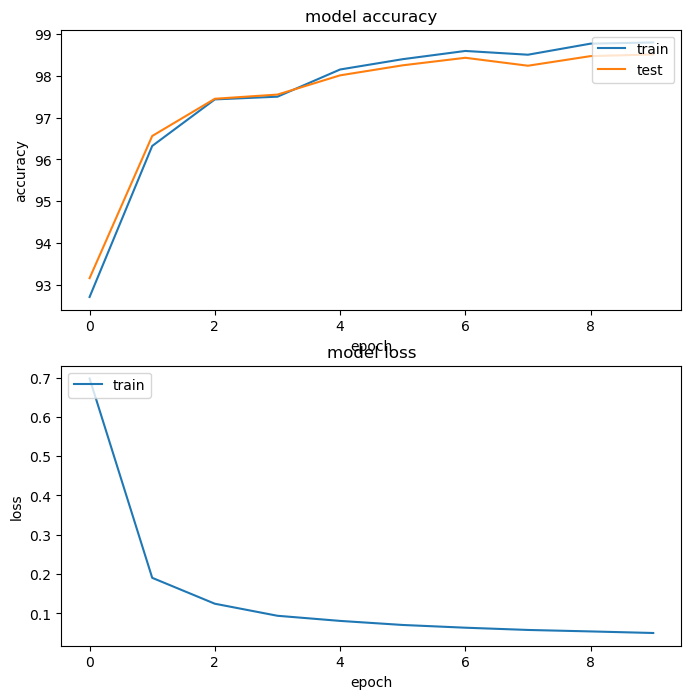

In [8]:
# plot training history
plt.figure(figsize=(8,8))

# History for accuracy
plt.subplot(211)
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

# History for loss
plt.subplot(212)
plt.plot(history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [9]:
# Define confusion matrix
def calc_error(predictions, labels):
    """Return the error rate and confusions."""
    correct = np.sum(predictions == labels)
    print(predictions.shape)
    total = predictions.shape[0]

    error = 100.0 - (100 * float(correct) / float(total))

    confusions = np.zeros([10, 10], np.float32)
    bundled = zip(predictions, labels)
    for predicted, actual in bundled:
        confusions[predicted, actual] += 1

    return error, confusions

def get_predictions(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    all_predictions = []
    all_labels = []

    with torch.no_grad():  # Disable gradient calculation for inference
        for images, labels in tqdm(data_loader):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)  # Get logits
            _, predicted = torch.max(outputs.data, 1)  # Get predicted class indices

            all_predictions.append(predicted.cpu().numpy())  # Append predictions to list
            all_labels.append(labels.cpu().numpy())  # Append true labels to list

    # Concatenate all predictions and labels into single numpy arrays
    return np.concatenate(all_predictions), np.concatenate(all_labels)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 27.31it/s]


(10000,)
Test error: 1.5%


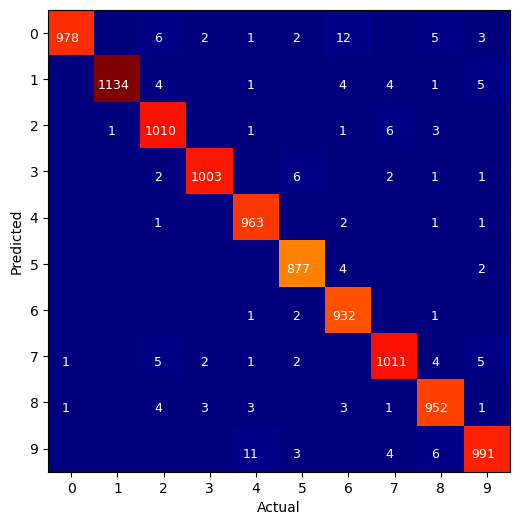

In [10]:
# Model predictions and confusion matrix
test_predictions, test_labels = get_predictions(model, DataLoader(mnist_test, batch_size=512, shuffle=True), device)
test_error, test_conf_mat = calc_error(test_predictions, test_labels)
print('Test error: %.1f%%' % test_error)

plt.figure(figsize=(6, 6))
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(False)
plt.xticks(np.arange(num_classes))
plt.yticks(np.arange(num_classes))
plt.imshow(test_conf_mat, cmap=plt.cm.jet, interpolation='nearest');

for i, cas in enumerate(test_conf_mat):
    for j, count in enumerate(cas):
        if count > 0:
            xoff = .07 * len(str(count))
            plt.text(j-xoff, i+.2, int(count), fontsize=9, color='white')

**2) Using AlexNet on the Fashion MNIST dataset** \\
Inspired by: https://github.com/eweill/keras-deepcv \\
AlexNet Paper:
https://proceedings.neurips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf

**The Alexnet model**
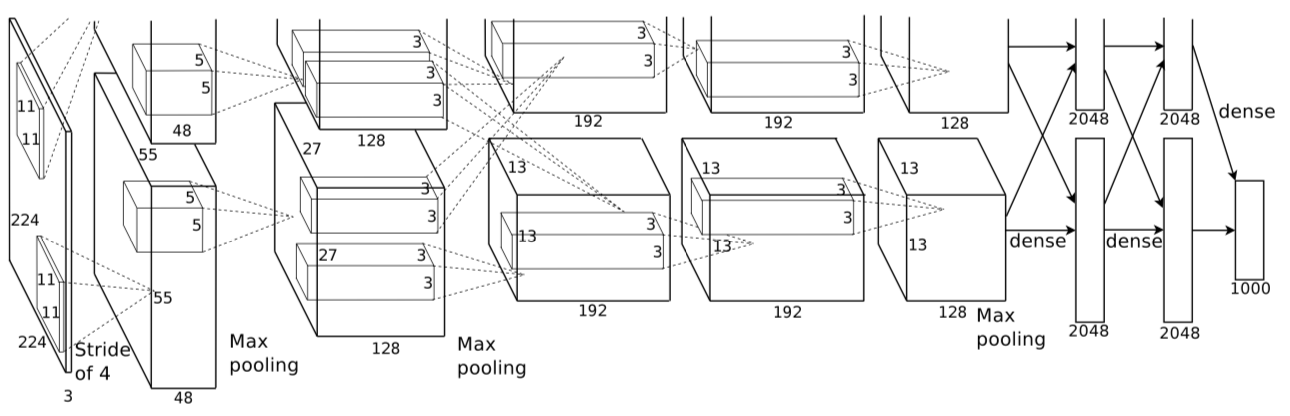

In [11]:
# Load Fashion MNIST dataset
transforms = Compose([ToTensor(), Normalize(0.5, 1)])
fmnist_train = FashionMNIST(".", download=True, train=True, transform=transforms)
fmnist_test = FashionMNIST(".", download=True, train=False, transform=transforms)

print(f"{len(fmnist_train)=}")
print(f"{len(fmnist_test)=}")

img, label = fmnist_train[0]
print(f"{img.shape=}")
print(f"{label=}")
CLASS_DESC = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
num_classes = 10

len(fmnist_train)=60000
len(fmnist_test)=10000
img.shape=torch.Size([1, 28, 28])
label=9


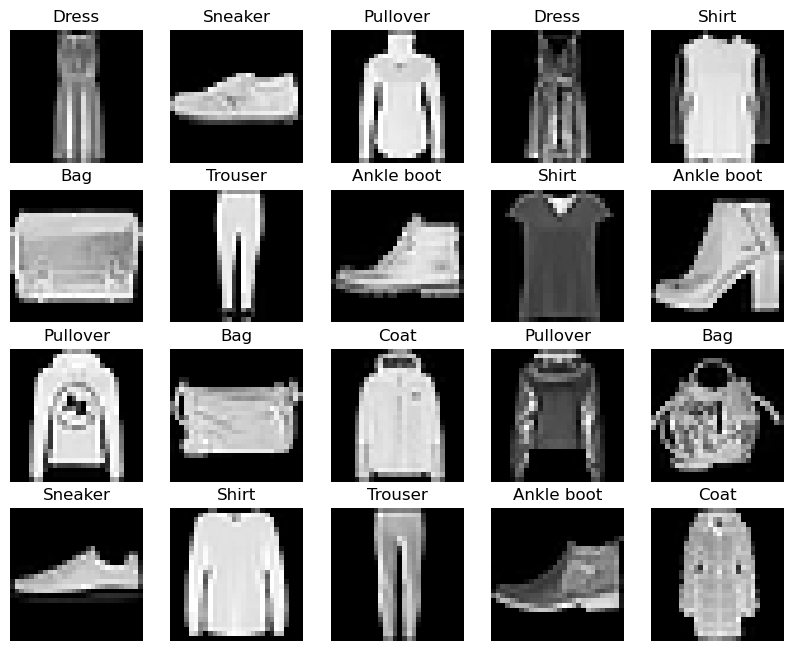

In [12]:
# Visualize the dataset
plt.figure(figsize=(10,10))
sample_img_idx = np.random.randint(0, len(fmnist_train), 20)
for i, j in enumerate(sample_img_idx):
    image, label = fmnist_train[j]
    ax=plt.subplot(5,5,i+1)
    plt.imshow(image[0], cmap=pyplot.get_cmap('gray'))
    plt.title(CLASS_DESC[label])
    plt.axis('off')

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AlexNet(nn.Module):
    def __init__(self, img_shape=(1, 28, 28), n_classes=10):
        super(AlexNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=img_shape[0], out_channels=96, kernel_size=(11, 11), padding='same')
        self.bn1 = nn.BatchNorm2d(96)
        
        self.conv2 = nn.Conv2d(96, 256, kernel_size=(5, 5), padding='same')
        self.bn2 = nn.BatchNorm2d(256)
        
        self.conv3 = nn.Conv2d(256, 512, kernel_size=(3, 3), padding='same')
        self.bn3 = nn.BatchNorm2d(512)
        
        self.conv4 = nn.Conv2d(512, 1024, kernel_size=(3, 3), padding='same')
        self.bn4 = nn.BatchNorm2d(1024)
        
        self.conv5 = nn.Conv2d(1024, 1024, kernel_size=(3, 3), padding='same')
        self.bn5 = nn.BatchNorm2d(1024)

        self.fc1 = nn.Linear(1024 * (img_shape[1] // 16) * (img_shape[2] // 16), 3072)
        self.bn6 = nn.BatchNorm1d(3072)
        
        self.fc2 = nn.Linear(3072, 4096)
        self.bn7 = nn.BatchNorm1d(4096)

        self.fc3 = nn.Linear(4096, n_classes)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Layer 1
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, kernel_size=2)

        # Layer 2
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, kernel_size=2)

        # Layer 3
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, kernel_size=2)

        # Layer 4
        x = F.relu(self.bn4(self.conv4(x)))

        # Layer 5
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.max_pool2d(x, kernel_size=2)

        # Flatten and fully connected layers
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.bn6(self.fc1(x)))
        x = self.dropout(x)

        x = F.relu(self.bn7(self.fc2(x)))
        x = self.dropout(x)

        x = self.fc3(x)
        return F.softmax(x, dim=1)

In [19]:
# Create model and get summary
model = AlexNet(img_shape=(1, 28, 28), n_classes = num_classes)
model.to(device)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0001)
history = train(model, optimizer, fmnist_train, fmnist_test, 5)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [01:30<00:00,  1.30it/s]


Epoch [1/5], Loss: 1.6758


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [02:18<00:00,  1.17s/it]


Epoch [2/5], Loss: 1.5895


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [02:08<00:00,  1.09s/it]


Epoch [3/5], Loss: 1.5710


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [02:08<00:00,  1.09s/it]


Epoch [4/5], Loss: 1.5613


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [02:08<00:00,  1.09s/it]


Epoch [5/5], Loss: 1.5526
Training complete!


In [ ]:
aug_transforms = Compose([ToTensor(), RandomHorizontalFlip(), Normalize(0.5, 1)])
fmnist_train_with_aug = FashionMNIST(".", download=True, train=True, transform=aug_transforms)
fmnist_test_with_aug = FashionMNIST(".", download=True, train=False, transform=transforms)
# Create model and get summary
model_with_aug = AlexNet(img_shape=(1, 28, 28), n_classes = num_classes)
model_with_aug.to(device)
optimizer = torch.optim.RMSprop(model_with_aug.parameters(), lr=0.0001)
history_with_aug = train(model_with_aug, optimizer, fmnist_train_with_aug, fmnist_test_with_aug, 5)

 26%|█████████████████████████████████████▊                                                                                                          | 31/118 [00:23<01:05,  1.33it/s]

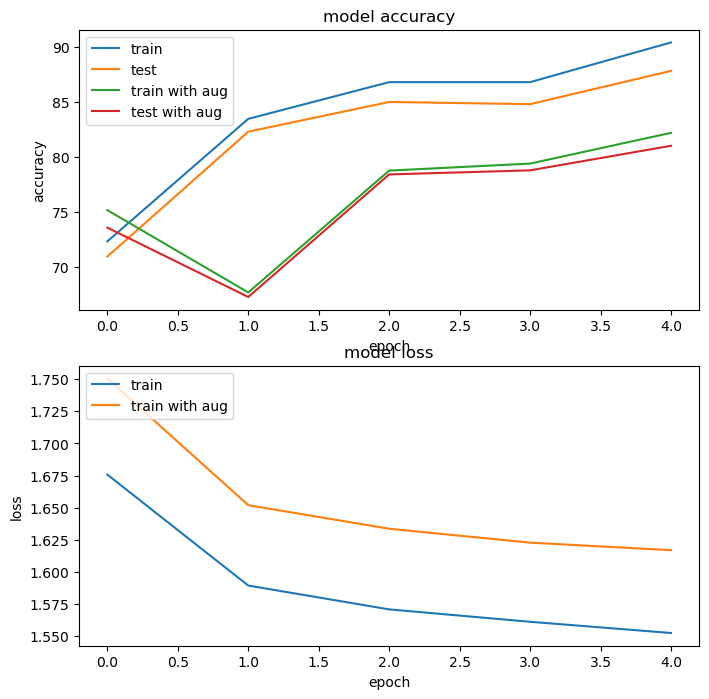

In [21]:
plt.figure(figsize=(8,8))

# History for accuracy
plt.subplot(211)
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.plot(history_with_aug['accuracy'])
plt.plot(history_with_aug['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test', 'train with aug', 'test with aug'], loc='upper left')

# History for loss
plt.subplot(212)
plt.plot(history['loss'])
plt.plot(history_with_aug['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'train with aug'], loc='upper left')
plt.show()

In [22]:
# Model predictions and confusion matrix
test_predictions, test_labels = get_predictions(model, test_loader, device)
test_error, test_conf_mat = calc_error(test_predictions, test_labels)
print('Test error: %.1f%%' % test_error)

plt.figure(figsize=(6, 6))
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(False)
plt.xticks(np.arange(num_classes))
plt.yticks(np.arange(num_classes))
plt.imshow(test_conf_mat, cmap=plt.cm.jet, interpolation='nearest');

for i, cas in enumerate(test_conf_mat):
    for j, count in enumerate(cas):
        if count > 0:
            xoff = .07 * len(str(count))
            plt.text(j-xoff, i+.2, int(count), fontsize=9, color='white')

NameError: name 'test_loader' is not defined